In [137]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.precision', 1)

## Read in data

In [ ]:
colnames = list(pd.read_csv('data/colnames.csv', header=None).loc[:,0])

df_raw = pd.read_csv('data/ICOWdyadyr.csv', header=0, names=colnames, low_memory=False)
df_raw.sample(10)

## Remove irrelevant and extraneous columns

In [ ]:
df = df_raw.dropna(axis=1)

dropcols = 'issue claimdy claim dyadnum chal tgt version'.split()

df = df.drop(dropcols, axis=1)

# REMOVE:
#  issue
#  claimdy
#  claim
#  dyadnum
#  chal
#  tgt
#  dyad
#  version
#  ~year

## Replace categorical columns with dummy variable columns

In [ ]:
# region
region_names = ['west_hemi', 'europe', 'mid_east']
region_dummies = pd.get_dummies(df.region)
region_dummies.columns = region_names
region_dummies

df = df.drop('region', axis=1)
df = pd.concat([df_, region_dummies], axis=1)
df

In [ ]:
df.shape
df.region.value_counts()

## EDA pair plots

In [82]:
df_y = df['attanyp']
df_ = df.iloc[:,20:30]
df_['TARGET'] = df_y
df_.columns

Index(['midissyr', 'maxhost', 'maxfatal', 'nfatal', 'midfatyr', 'nwar',
       'waryr', 'attemptsp', 'attemptst', 'attanyp', 'TARGET'],
      dtype='object')

In [83]:
df_

,midissyr,maxhost,maxfatal,nfatal,midfatyr,nwar,waryr,attemptsp,attemptst,attanyp,TARGET
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,1,1
2,0,0,0,0,0,0,0,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10036,0,0,0,0,0,0,0,0,0,0,0
10037,0,0,0,0,0,0,0,0,0,0,0
10038,0,0,0,0,0,0,0,0,0,0,0
10039,0,0,0,0,0,0,0,0,0,0,0


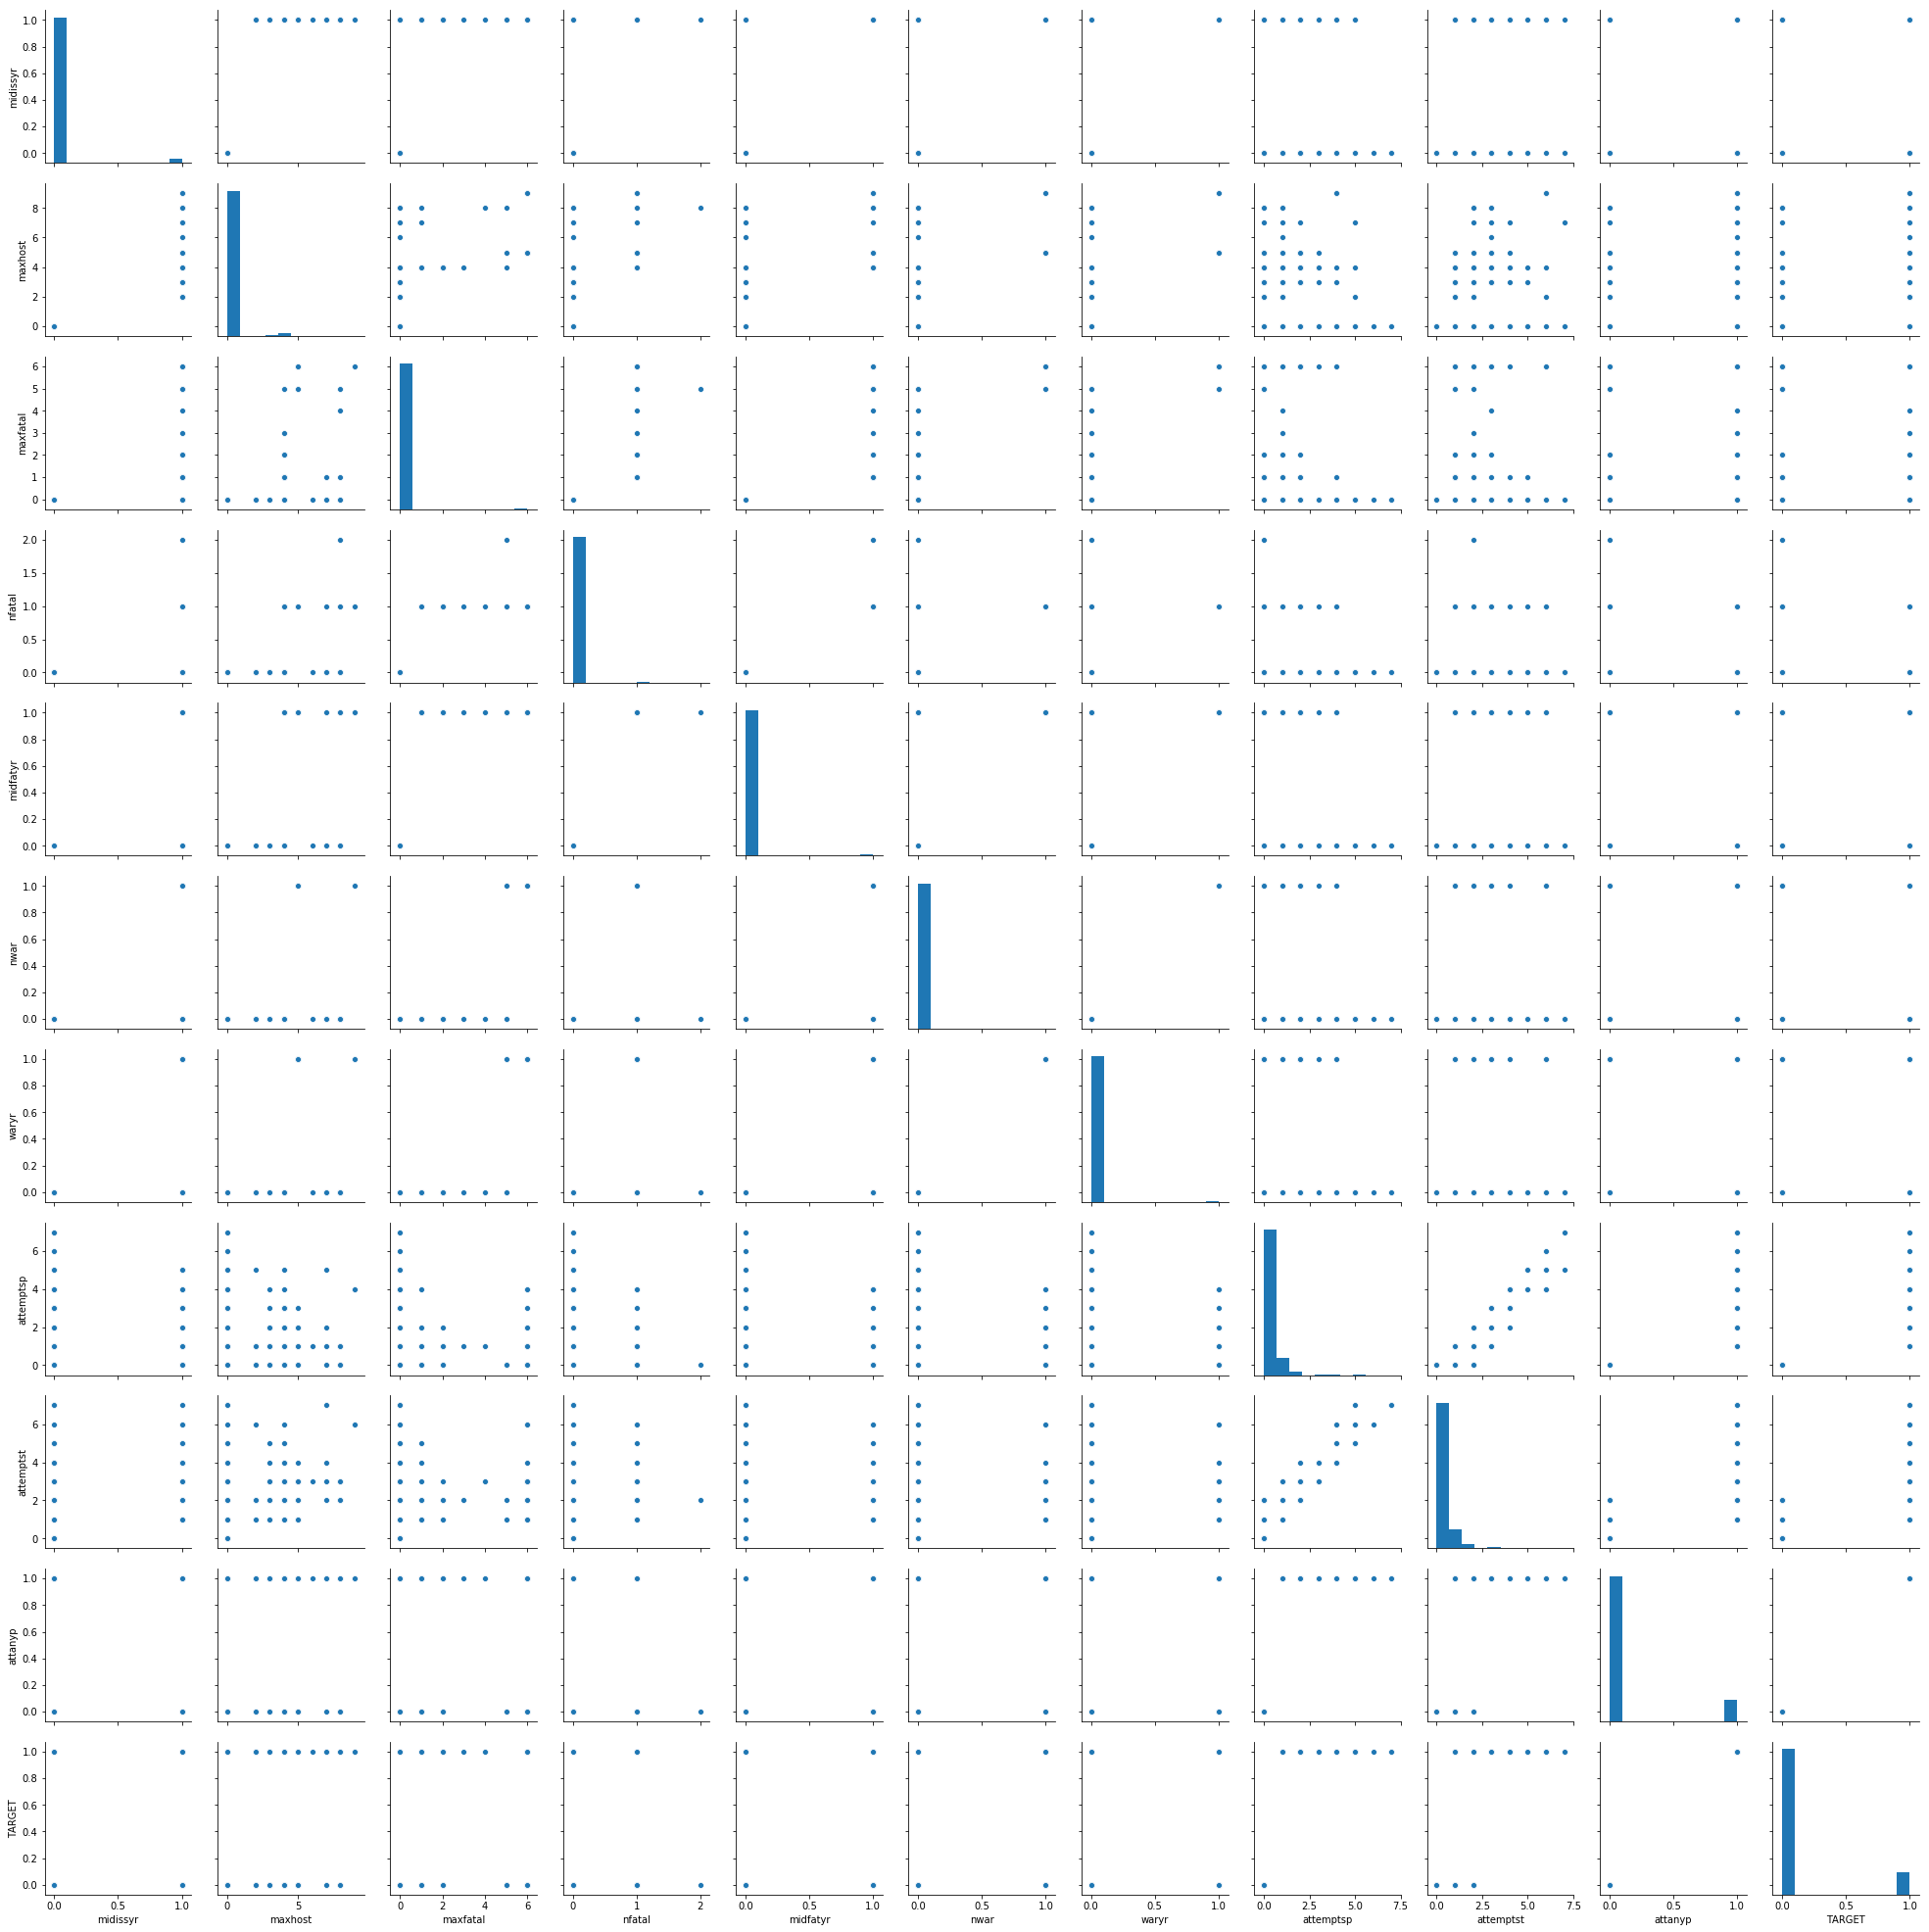

In [84]:
pairfig = sns.pairplot(data=df_)

## Basic random forest MVP

In [146]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [147]:
y = df.attanyp
X = df.drop('attanyp', axis=1)

In [148]:
randseed = 6

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=randseed)

In [152]:
# Create the model with 100 trees
rfm = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt')

# Fit on training data
rfm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [153]:
# train set
train_rfm_predictions = rfm.predict(X_train)
train_rfm_probs = rfm.predict_proba(X_train)[:, 1]

# test set
rfm_predictions = rfm.predict(X_test)
rfm_probs = rfm.predict_proba(X_test)[:, 1]

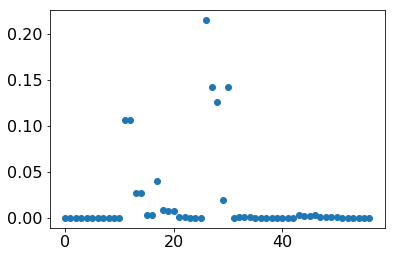

In [180]:
rfm.feature_importances_
plt.plot(rfm.feature_importances_, 'o')
#pd.DataFrame([rfm_predictions, y_test])

Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.13 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


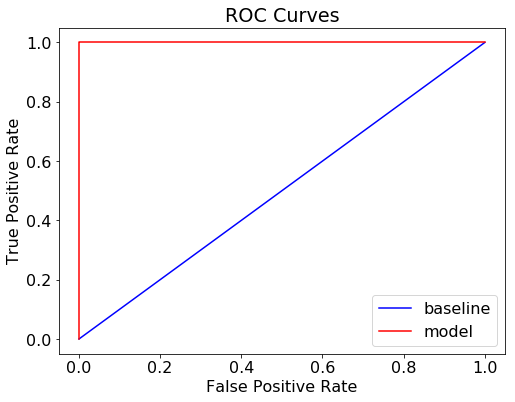

In [154]:
evaluate_model(rfm_predictions, rfm_probs, train_rfm_predictions, train_rfm_probs)

In [130]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

In [128]:
rf_probs

array([0., 1., 0., ..., 1., 0., 1.])